In [1]:
#可視化 & 前処理
import MySQLdb
from getpass import getpass
import utils
from matplotlib import pyplot as plt
import datetime
import time
import sys
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN,SpectralClustering
import numpy as np
from sklearn.metrics.pairwise import manhattan_distances,euclidean_distances
from sklearn.neighbors import kneighbors_graph
#from scipy.spatial.distance import jaccard,dice,kulsinski,mahalanobis
#from sklearn.cluster import k_means_
import matplotlib
import random
import pandas as pd
import folium
from folium.features import DivIcon
from collections import OrderedDict
import pickle
#import networkx as nx
%config InlineBackend.figure_formats = {'png', 'retina'}
#matplotlib notebook

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
interval = 15 #[minutes]
clustering_auto = False

In [3]:
conn = MySQLdb.connect(db="smartsantander",user="root",passwd=getpass())

········


In [4]:
cursor = conn.cursor()
cursor.execute("select distinct * from nodelocation;")
nodelocation = cursor.fetchall()

In [5]:
IDs,x,y = zip(*nodelocation)
idx2pid = {idx:pid for idx,pid in enumerate(IDs)}
pid2idx = {pid:idx for idx,pid in enumerate(IDs)}

In [6]:
locations = np.array(list(zip(x,y)))
if clustering_auto:
    kmeans = KMeans(n_clusters=1)
    labels = kmeans.fit_predict(locations)
    clusters = utils.ListDict()
    cluster2id = utils.ListDict()
    for i,tmp in enumerate(zip(labels,locations)):
        label,location = tmp
        cluster2id.append(label,i)
        clusters.append(label,location)
else:
    hoge = [
        list(range(3610,3616)) + list(range(3911,3915)),
        list(range(3616,3631)),
        list(range(3631,3636)),
        list(range(3636,3649)),
        list(range(3701,3707)),
        list(range(3707,3713)),
        list(range(3658,3672)),
        list(range(3713,3728)),
        list(range(3900,3906)),
        list(range(3804,3814)) + list(range(3779,3789)),
        list(range(3814,3820)) + list(range(3789,3795)),
        [3820,3821] + list(range(3795,3799)),
        list(range(3822,3827)) + list(range(3799,3804)),
        list(range(3919,3924)),
        list(range(3891,3900)) + list(range(3739,3748)),
        list(range(3753,3758)) + list(range(3748,3753)),
        list(range(3768,3773)) + list(range(3758,3763)),
        list(range(3773,3779)) + list(range(3763,3768)),
        list(range(3906,3911)) + list(range(3851,3856)) + list(range(3874,3880)),
        list(range(3856,3874)) + list(range(3880,3891)),
        list(range(3830,3837)),
        list(range(3672,3684)),
        list(range(3600,3610)),
        list(range(3728,3738)),
        list(range(3837,3842)) + list(range(3915,3919)) + list(range(3842,3851)),
        list(range(3684,3701)),
        list(range(3827,3830)) + list(range(3649,3658)),
    ]
    cluster2id = {i:list(map(lambda x:pid2idx[x],fuga)) for i,fuga in enumerate(hoge)}
    clusters = {clnum:[locations[idx] for idx in indexes] for clnum,indexes in cluster2id.items()}

In [7]:
colorlist = list(matplotlib.colors.cnames.keys())
random.shuffle(colorlist)

In [8]:
map1 = folium.Map(location=[43.462306, -3.80], zoom_start=17,
                  attr='&copy; <a href="http://osm.org/copyright">OpenStreetMap</a> contributors')
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
             'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
             'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
             'gray', 'black', 'lightgray']

for key,idxes in cluster2id.items():
    for i in idxes:
        folium.CircleMarker(
            locations[i],
            radius = 5,
            color = 'black',
            
            fill_color = colorlist[key],
            fill=True,
            popup='cluster: '+str(key)+', id: '+str(idx2pid[i]),
            fill_opacity=1,
        ).add_to(map1)



In [9]:
map1

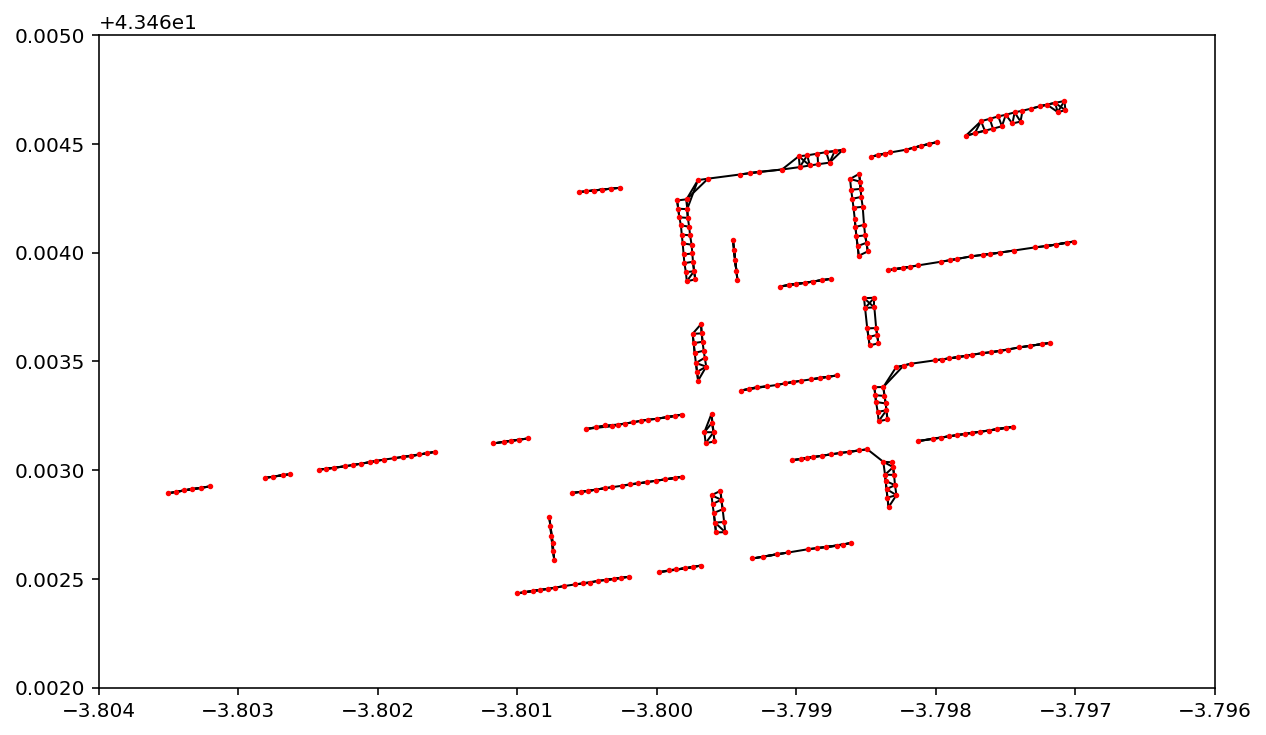

In [15]:
"""
t = kneighbors_graph(locations,3,metric='cityblock',mode='distance')
plt.figure(figsize=(10,6))
g = nx.Graph(t.toarray())
nx.draw_networkx_nodes(g,pos=locations[:,[1,0]],node_size=3)
nx.draw_networkx_edges(g,pos=locations[:,[1,0]],)
#nx.draw_networkx_edge_labels(g,pos=g)
#nx.draw_networkx(g,pos=locations[:,[1,0]],node_size=1,label_pos=None)     #頂点をサイクル上に並べてグラフを描画

plt.xlim(-3.804,-3.796)
plt.ylim(43.462,043.465)
plt.show()
"""

In [16]:
cursor.execute("select distinct NodeID from nodehistory;")
IDs = cursor.fetchall()

In [11]:
cursor.execute("select distinct * from nodehistory order by timestamp asc;")
tmp2 = cursor.fetchall()

In [28]:
IDs = set([pid for pid,_,_ in tmp2])

In [18]:
parking_status = utils.ListDict()

In [19]:
for pid,state,date in tmp2:
    parking_status.append(pid,(state,date))

In [20]:
results = []
for pid,status in parking_status.items():
    intervals = [(status[i][0],(status[i+1][1] - status[i][1])) for i in range(len(status) - 1)]
    try:
        res_df = pd.DataFrame(results)
        _,one_interval =zip(*list(filter(lambda x:x[0] == 1,intervals)))
    except:
        one_interval = [datetime.timedelta(0)]
    try:
        _,zero_interval =zip(*list(filter(lambda x:x[0] == 0,intervals)))
        
    except:
        zero_interval = [datetime.timedelta(0)]
    results.append(OrderedDict([
        ('pid',pid),
        ('e_mean',np.mean(zero_interval)),
        ('e_max',np.max(zero_interval)),
        ('e_min',np.min(zero_interval)),
        ('f_mean',np.mean(one_interval)),
        ('f_max',np.max(one_interval)),
        ('f_min',np.min(one_interval)),
    ]))
res_df = pd.DataFrame(results)

In [22]:
res_df.drop(135).sort_values(by='f_mean',ascending=False)[['pid','e_mean','f_mean']]

,pid,e_mean,f_mean
18,3618,0 days 03:06:16.440000,7 days 10:35:18.914286
17,3617,0 days 00:35:21.225152,2 days 15:19:34.824000
107,3707,0 days 02:37:34.745726,2 days 12:23:03.686825
16,3616,0 days 01:36:14.473978,2 days 09:10:02.781250
207,3808,0 days 00:20:46.430980,1 days 04:56:26.630019
25,3625,0 days 00:55:29.949521,1 days 02:34:25.867806
208,3809,0 days 01:23:35.917923,0 days 23:03:07.763158
20,3620,0 days 00:13:37.975451,0 days 15:37:45.152012
73,3673,0 days 00:21:28.398931,0 days 13:34:47.726876
145,3746,0 days 00:50:36.796043,0 days 13:11:12.743119


In [23]:
res_df[['e_mean','f_mean']].drop(135).mean()

e_mean   00:46:36.117195
f_mean   05:18:45.753126
dtype: timedelta64[ns]

In [24]:
start = tmp2[0][2]

In [25]:
trancate = lambda dt,it: dt.replace(
    minute=dt.minute - dt.minute%it,second=0,microsecond=0
)

In [32]:
id2index = {i:index for index,i in enumerate(IDs)}

In [34]:
log = utils.ListDict()
_ = []
timestamps = []
base_vec = np.empty(len(IDs))
base_vec.fill(None)
current_date = trancate(start,interval)

for i,record in enumerate(tmp2):
    #各パーキングごとに，インターバル内の最後の状態をそのインターバルにおける状態として採用する
    #インターバルの中で最後のレコードの状態を次のインターバルに引き継ぐ
    ID,state,datetime = record
    trancated = trancate(datetime,interval)
    if trancated.month != current_date.month:
        print(str(trancated))
    if current_date != trancated:
        timestamps.append(trancated)
        _.append(base_vec.copy())
        current_date = trancated
    else:
        base_vec[id2index[ID]] = state

    log.append(ID,(state,trancate(datetime,interval)))
    

2014-02-01 00:00:00
2014-03-13 18:00:00
2014-04-01 00:00:00
2014-05-01 00:00:00
2014-06-15 20:00:00
2014-07-01 00:00:00
2014-08-01 00:00:00
2014-09-01 00:00:00
2014-10-01 00:00:00
2014-11-01 00:15:00
2014-12-01 00:00:00
2015-01-01 00:00:00
2015-02-01 00:00:00
2015-03-01 00:00:00
2015-04-01 00:00:00
2015-05-01 00:00:00
2015-06-10 01:00:00
2015-07-01 00:00:00
2015-08-01 00:00:00
2015-09-01 00:00:00
2015-10-01 00:00:00
2015-11-01 00:00:00
2015-12-01 00:00:00
2016-01-01 00:00:00
2016-02-01 00:00:00
2016-03-01 00:00:00
2016-04-01 00:00:00
2016-05-01 00:00:00
2016-06-01 00:00:00
2016-07-01 00:00:00
2016-08-01 00:00:00
2016-09-01 00:00:00
2016-10-01 00:00:00
2016-11-01 00:00:00
2016-12-01 00:00:00
2017-01-01 00:00:00
2017-02-01 00:00:00
2017-03-01 00:00:00
2017-04-01 00:15:00
2017-05-01 00:00:00
2017-06-01 00:00:00
2017-08-12 12:30:00


In [35]:
results = np.nan_to_num(np.array(_))
results_n = np.nan_to_num(1 - np.array(_))

In [36]:
bbb = np.array([results[:,idx].sum(axis=1) for i,idx in cluster2id.items()]).T
ccc = np.array([results_n[:,idx].sum(axis=1) for i,idx in cluster2id.items()]).T

In [37]:
df = pd.DataFrame(bbb)
df_t = pd.DataFrame(ccc)
df_ts = pd.DataFrame(timestamps,columns=['timestamp'])

In [40]:
cluster_sizes = np.array([len(value) for key,value in sorted(cluster2id.items(),key=lambda x:x[0])])

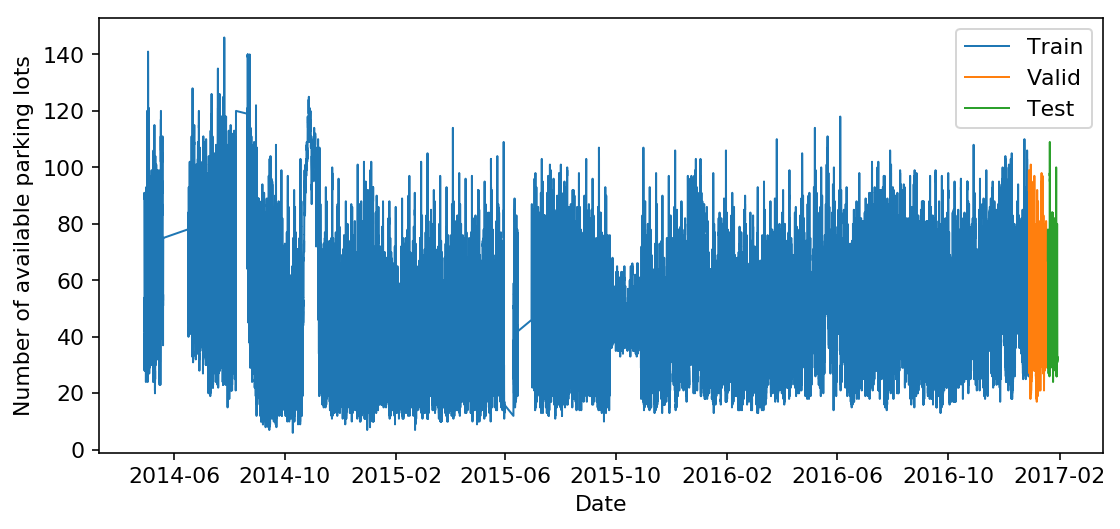

In [65]:
#from matplotlib import pyplot as plt
train_start, train_end = 8500, -15000
valid_start, valid_end = -15000,-13000
test_start,test_end = -13000,-12000
plt.rcParams["font.size"] =  11
plt.figure(figsize=(9,4))
#plt.plot(timestamps,df_t.sum(axis=1),color="gray",label="Unused",lw=1)
#plt.plot(timestamps[:0],df_t.sum(axis=1)[:0])
#plt.plot(timestamps[:0],df_t.sum(axis=1)[:0])
#plt.plot(timestamps[0:train_start],df_t.sum(axis=1)[0:train_start])
plt.plot(timestamps[train_start:train_end],df_t.sum(axis=1)[train_start:train_end],label="Train",lw=1)
plt.plot(timestamps[valid_start:valid_end],df_t.sum(axis=1)[valid_start:valid_end],label="Valid",lw=1)
plt.plot(timestamps[test_start:test_end],df_t.sum(axis=1)[test_start:test_end],label="Test",lw=1)

plt.ylabel("Number of available parking lots")
plt.xlabel("Date")
#plt.plot(timestamps[test_end:-1],df_t.sum(axis=1)[test_end:-1])

plt.legend(loc='upper right')
plt.xticks(rotation=0)
plt.savefig("original_available.pdf")
plt.show()

In [42]:
data = np.array(df)
data2 = np.nan_to_num(data)
data2 = data2 / cluster_sizes #[0,1] に正規化

In [57]:
datas = {
    "locations": locations,
    "cluster2id": cluster2id,
    "cluster_sizes": cluster_sizes,
    "timestamps": timestamps,
    "raw_data": data,
    "cluster_data": data2,
    "onehot_data": results,
}

In [59]:
pickle.dump(datas,file=open("./data/data.pickle","wb"))